# Organizing the input for the model: stimulus and errts timeseries.

### Daniela del Río
### Tuesday, April 22, 2025

First half of the notebook is based on `Aligning_stimulus_and_errts.ipynb` and the second half is based on `Mechanistic_model_with_data_sampling_rate.ipynb`.

Goal: Input should be a stimulus tag and a time when that stimulus was present (this could come from a matrix or not). Make sure that these times make sense based on the following matrix:
```
X_session1 = np.loadtxt("Session1/X_stim_matrix_session1_full_GLM.txt")  # list of stimulus times in seconds
print(X_session1.shape)
stim1_GLM = X_session1[:,0]
```
As output, you should have a single timeseries of 0s and scalar values when stimuli were present to then convolve with an HRF.

From all the files in EventFiles, import the first line, for both the right and left hand.

Then, convert that entry into the space where the timeseries is on. (2528, 76) txs

Only the first run/scan will be 316 entries

In [2]:
import math
import os
import numpy as np
import random as rd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from scipy import stats 

# commands to create high-resolution figures with large labels, credits Erin McKiernan
%config InlineBackend.figure_formats = {'png', 'retina'} 
plt.rcParams['axes.labelsize'] = 16 # fontsize for figure labels
plt.rcParams['axes.titlesize'] = 18 # fontsize for figure titles
plt.rcParams['font.size'] = 14 # fontsize for figure numbers
plt.rcParams['lines.linewidth'] = 1.4 # line width for plotting


### Obtain all the files from EventFiles folder, both left and right hand. 

In [4]:
folder = "Session1/EventFiles"

frequencies = list(range(100, 341, 30))        # 100 to 280 in steps of 30
conditions = [1, 2, 3, 4]
# Left (01–09) and Right (10–18)
numbering_L = [f"{i:02d}" for i in range(1, 10)]
numbering_R = [f"{i:02d}" for i in range(10, 19)]

# Loop and generate filenames
filenames = []

# Handle L side
for num, freq in zip(numbering_L, frequencies):
    for cond in conditions:
        fname = f"FreqAP08_{num}_L{freq}_{cond}.txt"
        fpath = os.path.join(folder, fname)
        try:
            # vec = create_binary_vector(fpath)
            # binary_matrix.append(vec)
            filenames.append(fname)
        except FileNotFoundError as e:
            print(f"Skipping: {e}")

# Handle R side (same frequencies!)
for num, freq in zip(numbering_R, frequencies):
    for cond in conditions:
        fname = f"FreqAP08_{num}_R{freq}_{cond}.txt"
        fpath = os.path.join(folder, fname)
        try:
            # vec = create_binary_vector(fpath)
            # binary_matrix.append(vec)
            filenames.append(fname)
        except FileNotFoundError as e:
            print(f"Skipping: {e}")
            

# Filter to get only filenames that end with "_4.txt"
files_cond1 = [f for f in filenames if f.endswith('_1.txt')]
files_cond2 = [f for f in filenames if f.endswith('_2.txt')]
files_cond3 = [f for f in filenames if f.endswith('_3.txt')]
files_cond4 = [f for f in filenames if f.endswith('_4.txt')]

# Show result
print(files_cond4)

['FreqAP08_01_L100_4.txt', 'FreqAP08_02_L130_4.txt', 'FreqAP08_03_L160_4.txt', 'FreqAP08_04_L190_4.txt', 'FreqAP08_05_L220_4.txt', 'FreqAP08_06_L250_4.txt', 'FreqAP08_07_L280_4.txt', 'FreqAP08_08_L310_4.txt', 'FreqAP08_09_L340_4.txt', 'FreqAP08_10_R100_4.txt', 'FreqAP08_11_R130_4.txt', 'FreqAP08_12_R160_4.txt', 'FreqAP08_13_R190_4.txt', 'FreqAP08_14_R220_4.txt', 'FreqAP08_15_R250_4.txt', 'FreqAP08_16_R280_4.txt', 'FreqAP08_17_R310_4.txt', 'FreqAP08_18_R340_4.txt']


In [5]:
# Modify the following function to provide 3 outputs
# Idea: In a single pass of the files you are interested, create 3 outputs:
# 1. Original space. original3
# 2. Converted space. transformed3_indices
# 3. Matrix with the whole timeseries. binary_vector

def first_binary_line(event_file_path, TR = 1.5, run_len = 316):# , nruns=8):
    # total_TRs = run_len * nruns # = 2528  # Replace with actual value from `3dinfo -nt`
    original3 = []
    transformed3 = []
    binary_vector = np.zeros(run_len) # total_TRs
    
    with open(event_file_path, "r") as f:
        for run_index, line in enumerate(f):
            if run_index == 0:
                line = line.strip()
                # if "*" in line:
                #     continue  # Skip lines with '*'
                # if not line:
                #     continue  # Skip empty lines
                # try:
                times = np.asarray([float(t) for t in line.split()])
                # except ValueError:
                #     continue  # Skip invalid lines just in case
                run_offset = (run_index) * run_len # run_index -1?

                tr_indices = [int(t / TR) + run_offset for t in times]
                for idx in tr_indices:
                    binary_vector[idx] = 1
                original3.append(times)
                transformed3.append(tr_indices)
            else:
                break

    return np.asarray(original3), np.asarray(transformed3), np.asarray(binary_vector)

In [6]:
# If I choose only 1 condition, say condition LXXX_4, and RXXX_4 that condition was presented in the first run.

print("Input: ", files_cond4)
original3_cond4 = []
transformed3_cond4 = []
binary_matrix_cond4 = []

for fname in files_cond4:
    fpath = os.path.join(folder, fname)
    
    try:
        og_vec, tr_vec, bin_vec = first_binary_line(fpath)
        # print(og_vec)
        original3_cond4.append(og_vec[0])
        transformed3_cond4.append(tr_vec[0])
        binary_matrix_cond4.append(bin_vec)
    
    except FileNotFoundError as e:
        print(f"Skipping: {e}")

print("Output: ")
print(original3_cond4)
print(transformed3_cond4)
print(np.asarray(binary_matrix_cond4).shape)
print("The following value should be less than 316: ", max([max(l) for l in transformed3_cond4]))

Input:  ['FreqAP08_01_L100_4.txt', 'FreqAP08_02_L130_4.txt', 'FreqAP08_03_L160_4.txt', 'FreqAP08_04_L190_4.txt', 'FreqAP08_05_L220_4.txt', 'FreqAP08_06_L250_4.txt', 'FreqAP08_07_L280_4.txt', 'FreqAP08_08_L310_4.txt', 'FreqAP08_09_L340_4.txt', 'FreqAP08_10_R100_4.txt', 'FreqAP08_11_R130_4.txt', 'FreqAP08_12_R160_4.txt', 'FreqAP08_13_R190_4.txt', 'FreqAP08_14_R220_4.txt', 'FreqAP08_15_R250_4.txt', 'FreqAP08_16_R280_4.txt', 'FreqAP08_17_R310_4.txt', 'FreqAP08_18_R340_4.txt']
Output: 
[array([  0. , 205.5, 219. ]), array([ 91.5, 307.5, 444. ]), array([169.5, 186. , 225. ]), array([211.5, 376.5, 391.5]), array([252. , 403.5, 462. ]), array([ 63. , 342. , 409.5]), array([141., 198., 273.]), array([ 69., 240., 330.]), array([ 97.5, 232.5, 297. ]), array([150., 258., 357.]), array([ 45., 291., 363.]), array([267. , 415.5, 424.5]), array([ 84. , 351. , 397.5]), array([ 39. , 133.5, 438. ]), array([  6. , 160.5, 430.5]), array([ 18. , 192. , 316.5]), array([ 12. ,  31.5, 121.5]), array([ 51. , 1

### Positive control.
Do the stimuli occur at the same time in the EventFiles as in the stim matrix? I.e. do the timepoints `transformed3_cond4` correspond to stimulus from 
```
X_session1 = np.loadtxt("Session1/X_stim_matrix_session1_full_GLM.txt")  # list of stimulus times in seconds
print(X_session1.shape)
stim1_GLM = X_session1[:,0]
```
For the first 316 entries?

You could probe for this by plotting independently each of the stimulus frequencies with their respective hand. So build a plot for every stimulus with the timeseries from this matrix and as vertical lines the timepoints in `transformed3_cond4`.

Remember the mapping is different.

Obtain the mapping of the `X_session1` that match to the 18 stimuli you are interested in plotting.

$stim_dir/${subj}_01_L100_1.txt                \
            $stim_dir/${subj}_02_L130_1.txt                \
            $stim_dir/${subj}_03_L160_1.txt                \
            $stim_dir/${subj}_04_L190_1.txt                \
            $stim_dir/${subj}_05_L220_1.txt                \
            $stim_dir/${subj}_06_L250_1.txt                \
            $stim_dir/${subj}_07_L280_1.txt                \
            $stim_dir/${subj}_08_L310_1.txt                \
            $stim_dir/${subj}_09_L340_1.txt                \
            $stim_dir/${subj}_10_R100_1.txt                \
            $stim_dir/${subj}_11_R130_1.txt                \
            $stim_dir/${subj}_12_R160_1.txt                \
            $stim_dir/${subj}_13_R190_1.txt                \
            $stim_dir/${subj}_14_R220_1.txt                \
            $stim_dir/${subj}_15_R250_1.txt                \
            $stim_dir/${subj}_16_R280_1.txt                \
            $stim_dir/${subj}_17_R310_1.txt                \
            $stim_dir/${subj}_18_R340_1.txt                \
            $stim_dir/${subj}_19_ODDB_1.txt                \
            $stim_dir/${subj}_01_L100_2.txt                \
            $stim_dir/${subj}_02_L130_2.txt                \
            $stim_dir/${subj}_03_L160_2.txt                \
            $stim_dir/${subj}_04_L190_2.txt                \
            $stim_dir/${subj}_05_L220_2.txt                \
            $stim_dir/${subj}_06_L250_2.txt                \
            $stim_dir/${subj}_07_L280_2.txt                \
            $stim_dir/${subj}_08_L310_2.txt                \
            $stim_dir/${subj}_09_L340_2.txt                \
            $stim_dir/${subj}_10_R100_2.txt                \
            $stim_dir/${subj}_11_R130_2.txt                \
            $stim_dir/${subj}_12_R160_2.txt                \
            $stim_dir/${subj}_13_R190_2.txt                \
            $stim_dir/${subj}_14_R220_2.txt                \
            $stim_dir/${subj}_15_R250_2.txt                \
            $stim_dir/${subj}_16_R280_2.txt                \
            $stim_dir/${subj}_17_R310_2.txt                \
            $stim_dir/${subj}_18_R340_2.txt                \
            $stim_dir/${subj}_19_ODDB_2.txt                \
            $stim_dir/${subj}_01_L100_3.txt                \
            $stim_dir/${subj}_02_L130_3.txt                \
            $stim_dir/${subj}_03_L160_3.txt                \
            $stim_dir/${subj}_04_L190_3.txt                \
            $stim_dir/${subj}_05_L220_3.txt                \
            $stim_dir/${subj}_06_L250_3.txt                \
            $stim_dir/${subj}_07_L280_3.txt                \
            $stim_dir/${subj}_08_L310_3.txt                \
            $stim_dir/${subj}_09_L340_3.txt                \
            $stim_dir/${subj}_10_R100_3.txt                \
            $stim_dir/${subj}_11_R130_3.txt                \
            $stim_dir/${subj}_12_R160_3.txt                \
            $stim_dir/${subj}_13_R190_3.txt                \
            $stim_dir/${subj}_14_R220_3.txt                \
            $stim_dir/${subj}_15_R250_3.txt                \
            $stim_dir/${subj}_16_R280_3.txt                \
            $stim_dir/${subj}_17_R310_3.txt                \
            $stim_dir/${subj}_18_R340_3.txt                \
            $stim_dir/${subj}_19_ODDB_3.txt                \
            $stim_dir/${subj}_01_L100_4.txt                \
            $stim_dir/${subj}_02_L130_4.txt                \
            $stim_dir/${subj}_03_L160_4.txt                \
            $stim_dir/${subj}_04_L190_4.txt                \
            $stim_dir/${subj}_05_L220_4.txt                \
            $stim_dir/${subj}_06_L250_4.txt                \
            $stim_dir/${subj}_07_L280_4.txt                \
            $stim_dir/${subj}_08_L310_4.txt                \
            $stim_dir/${subj}_09_L340_4.txt                \
            $stim_dir/${subj}_10_R100_4.txt                \
            $stim_dir/${subj}_11_R130_4.txt                \
            $stim_dir/${subj}_12_R160_4.txt                \
            $stim_dir/${subj}_13_R190_4.txt                \
            $stim_dir/${subj}_14_R220_4.txt                \
            $stim_dir/${subj}_15_R250_4.txt                \
            $stim_dir/${subj}_16_R280_4.txt                \
            $stim_dir/${subj}_17_R310_4.txt                \
            $stim_dir/${subj}_18_R340_4.txt                \
            $stim_dir/${subj}_19_ODDB_4.txt                \

In [8]:
X_session1 = np.loadtxt("Session1/X_stim_matrix_session1_full_GLM.txt")  # list of stimulus times in seconds
print(X_session1.shape)

(2528, 76)


In [9]:
condition_4_X_from_full_GLM = X_session1[:, 57:75]
condition_4_X_from_full_GLM.shape

(2528, 18)

In [10]:
np.asarray(transformed3_cond4[0]).shape
print(transformed3_cond4[0])
transformed3_cond4[0][0]

[  0 137 146]


0

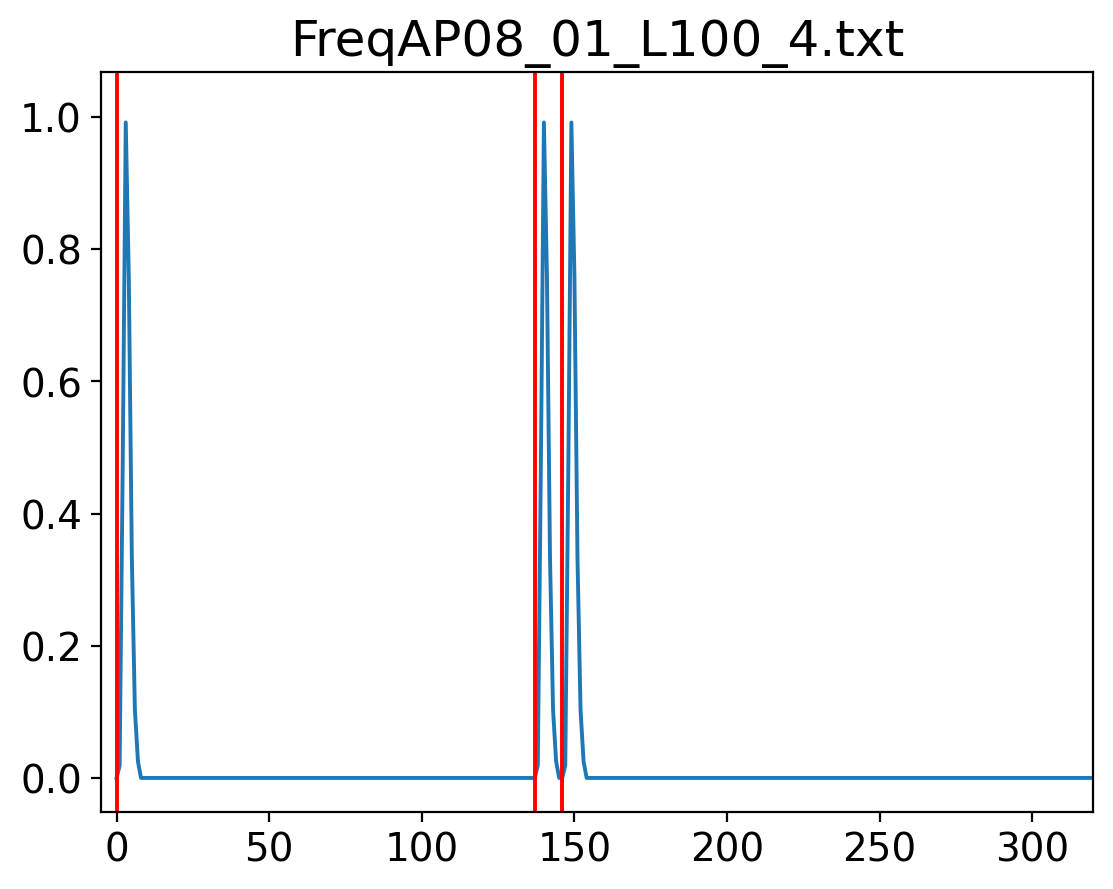

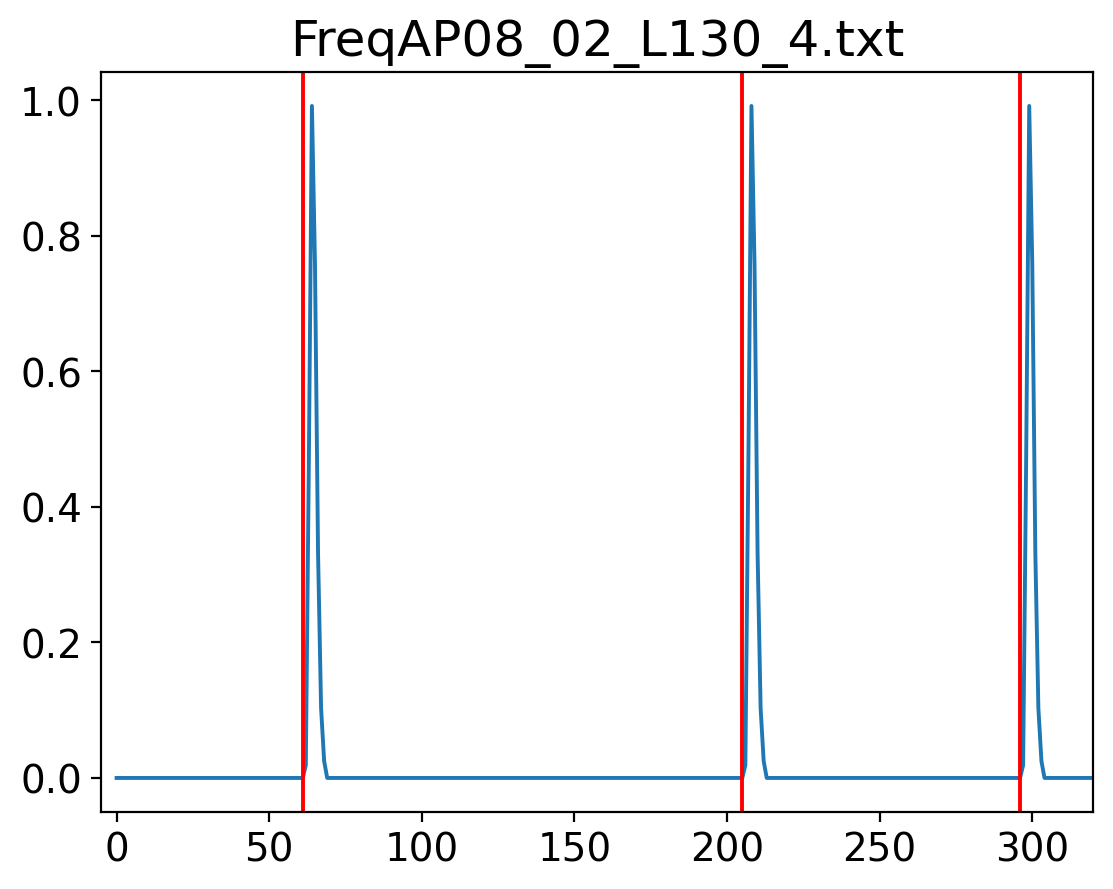

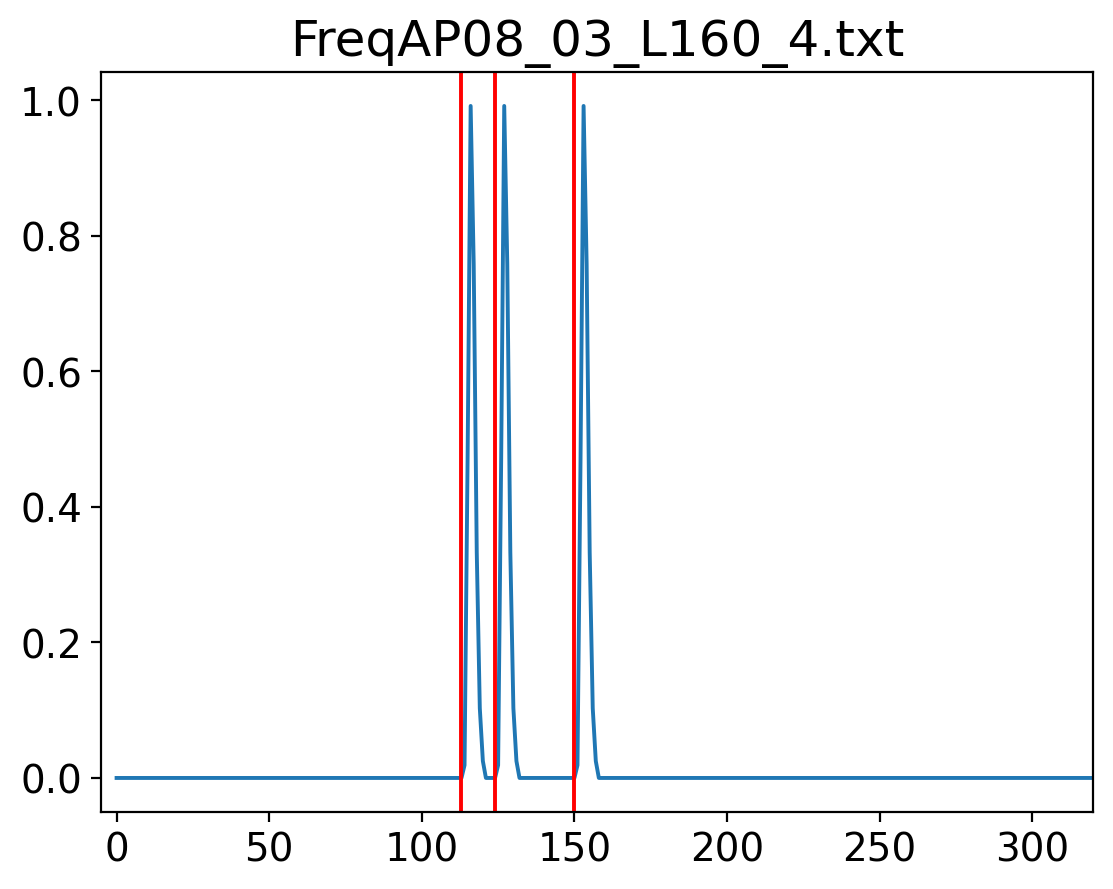

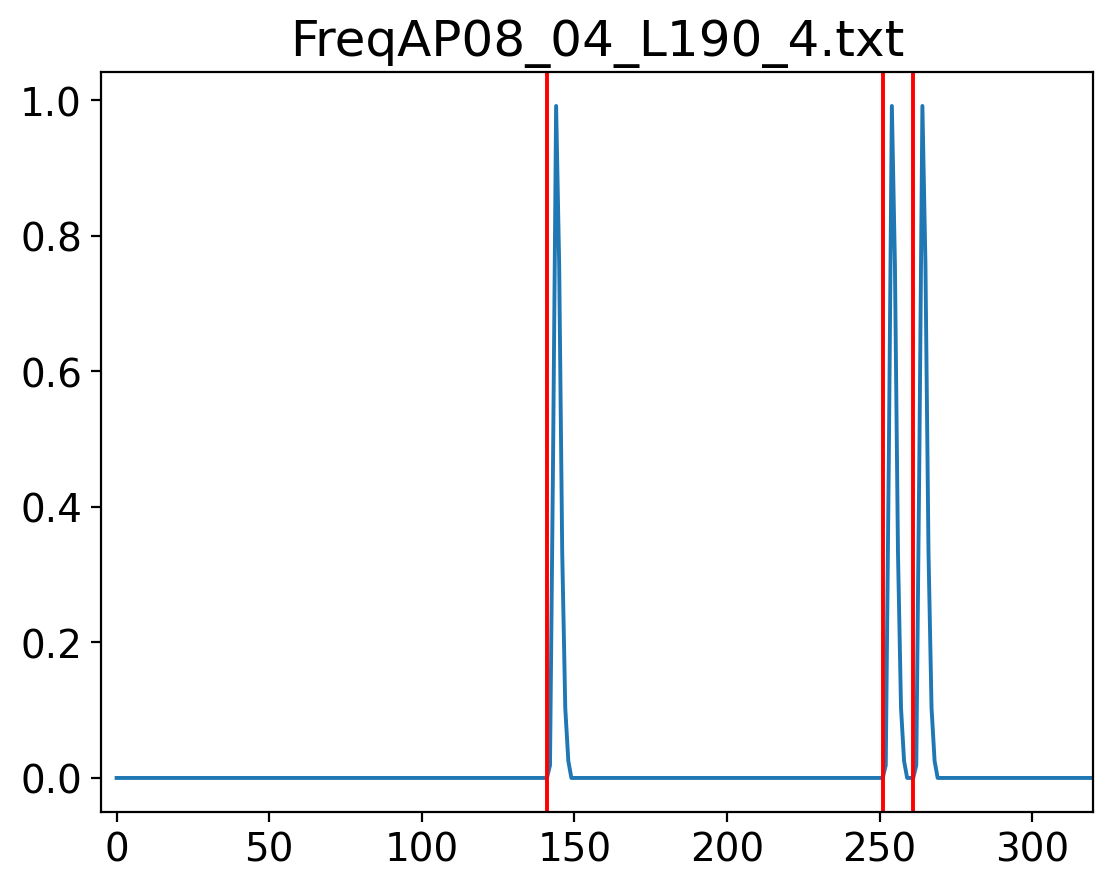

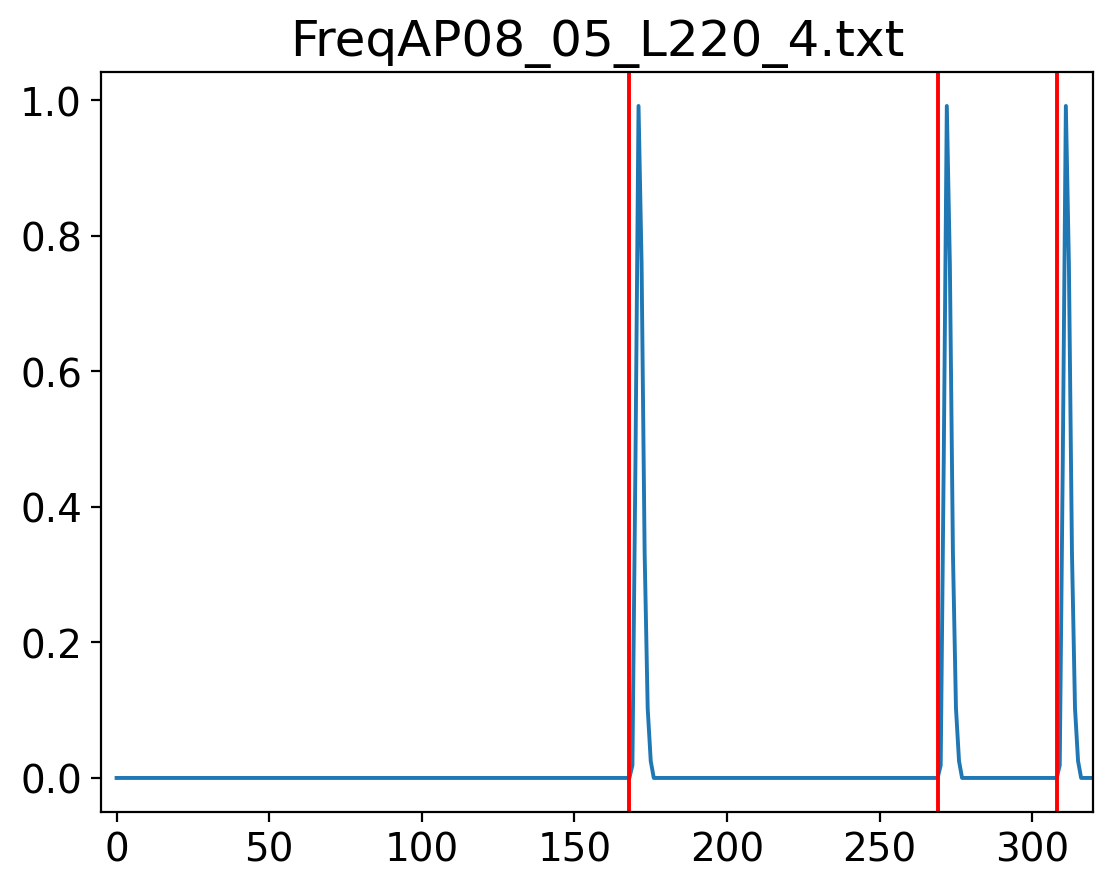

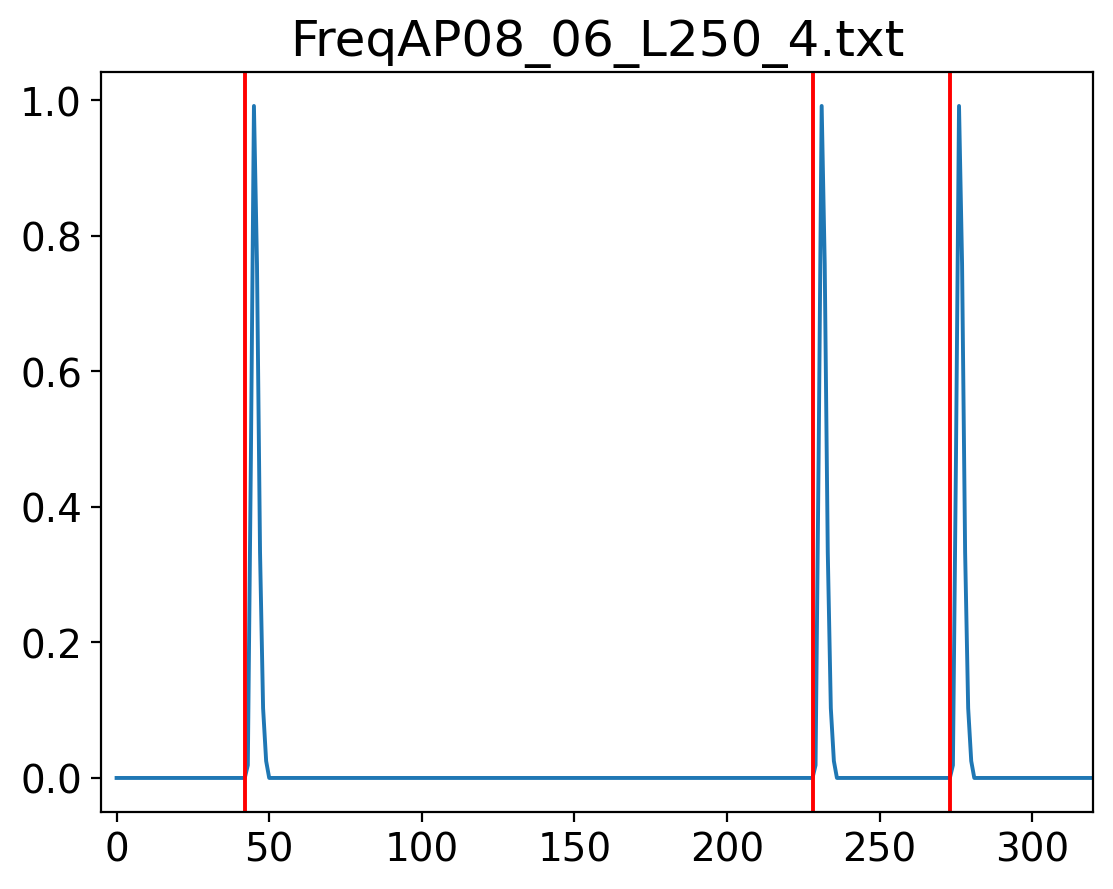

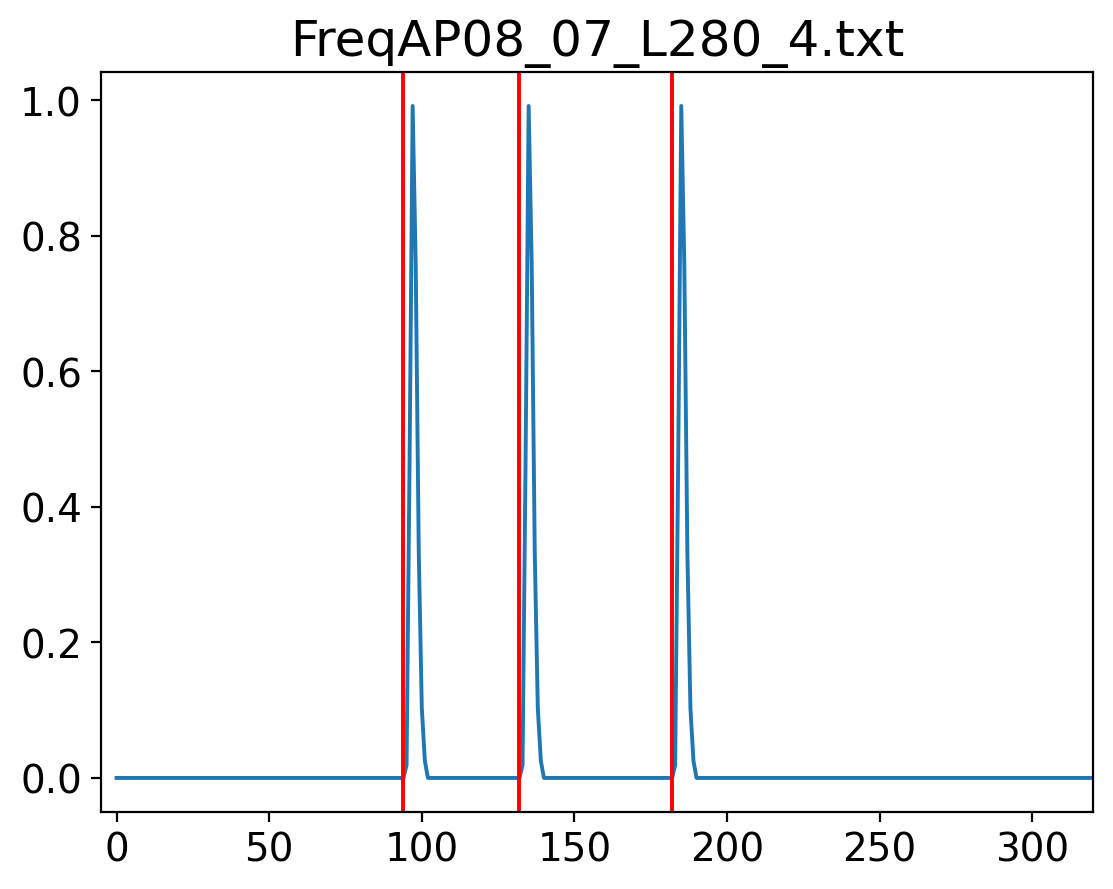

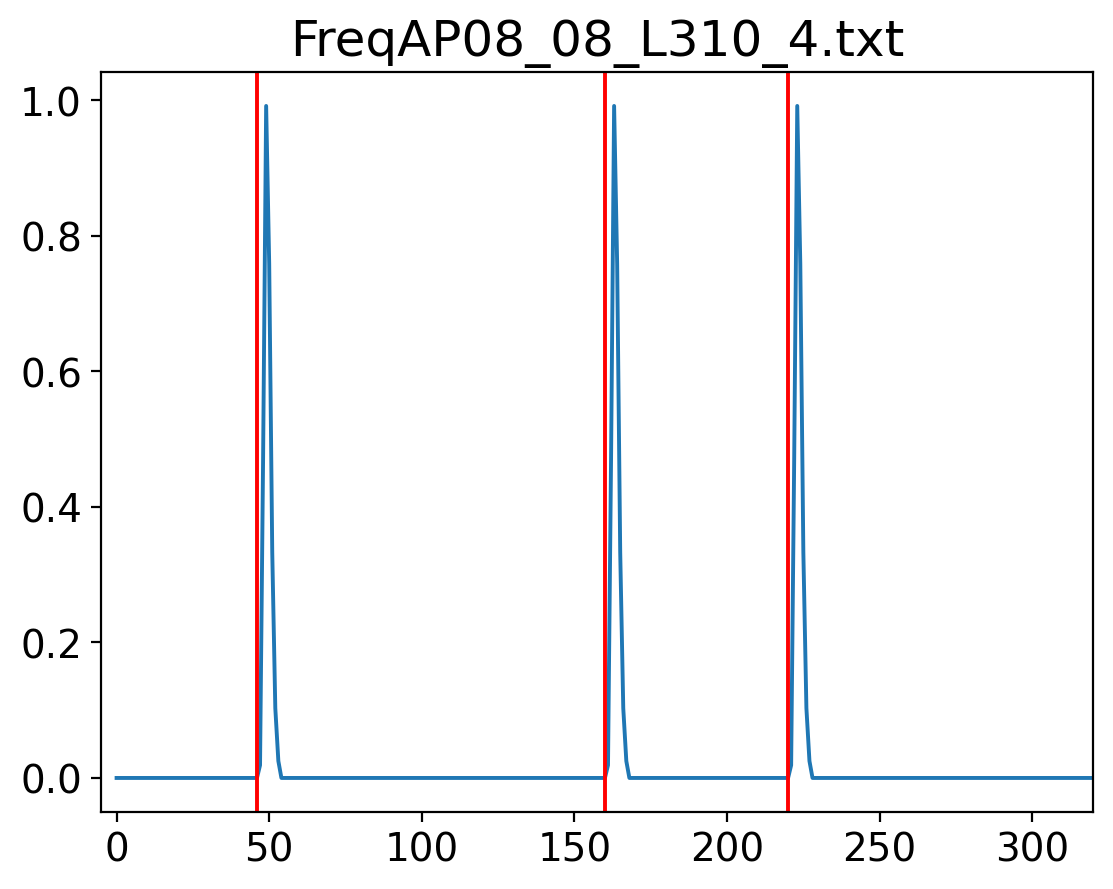

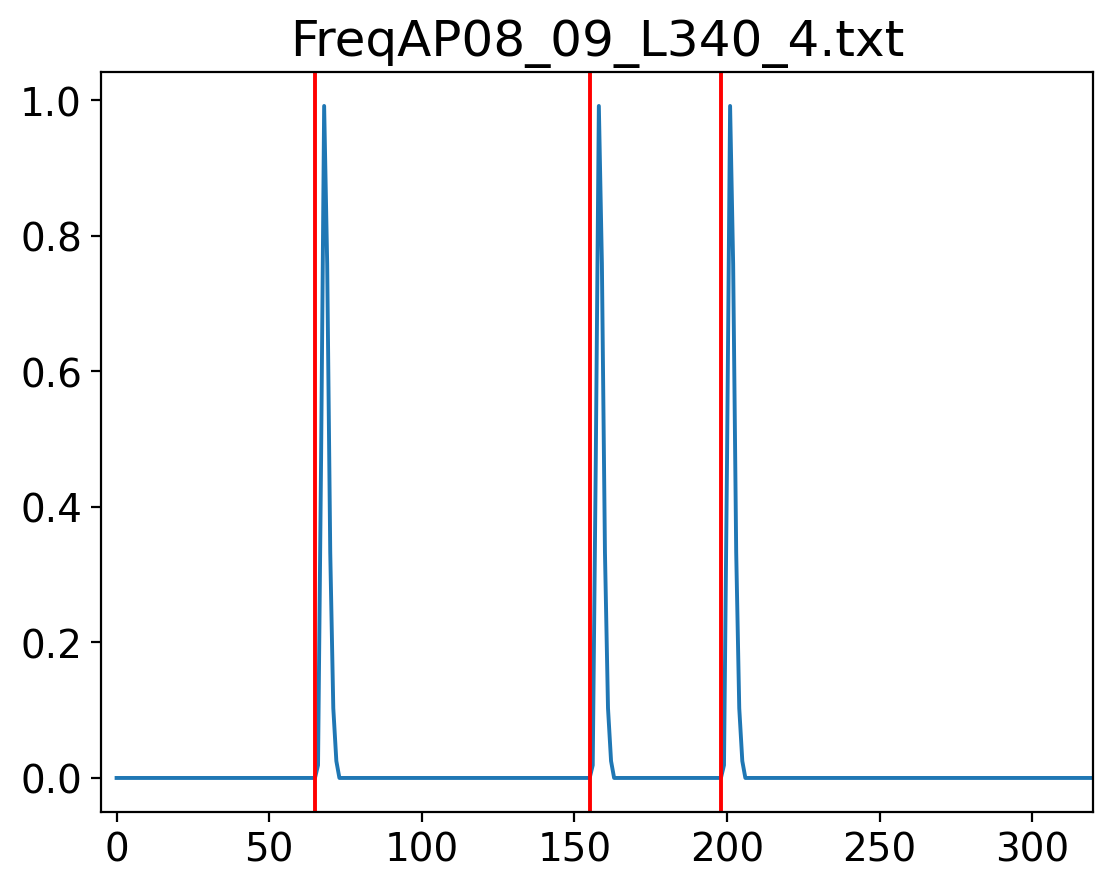

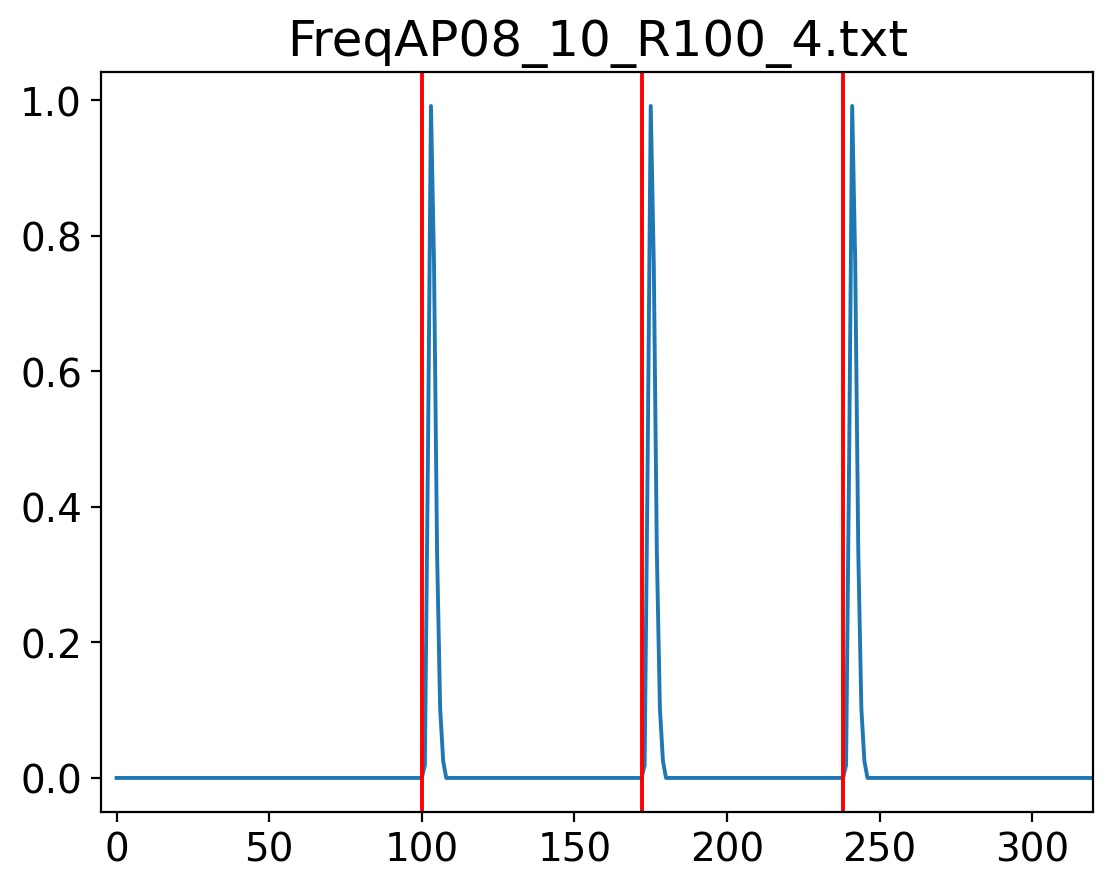

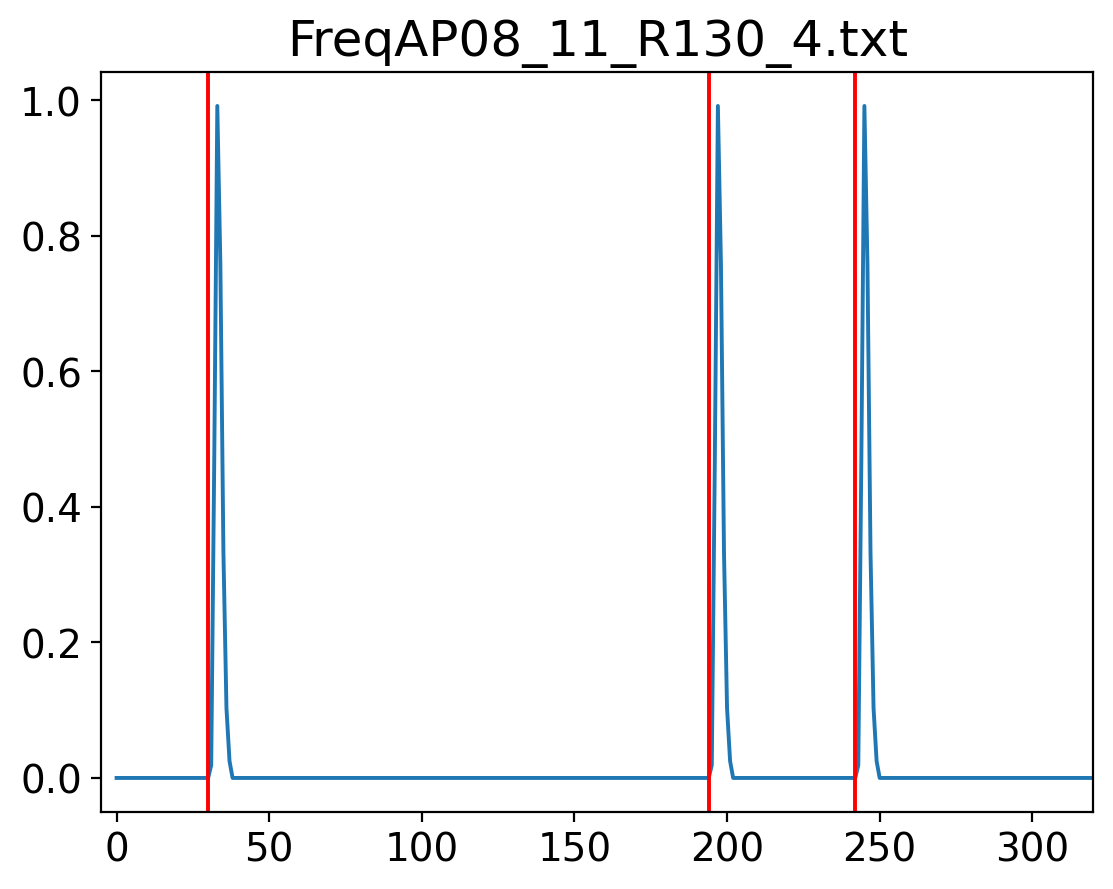

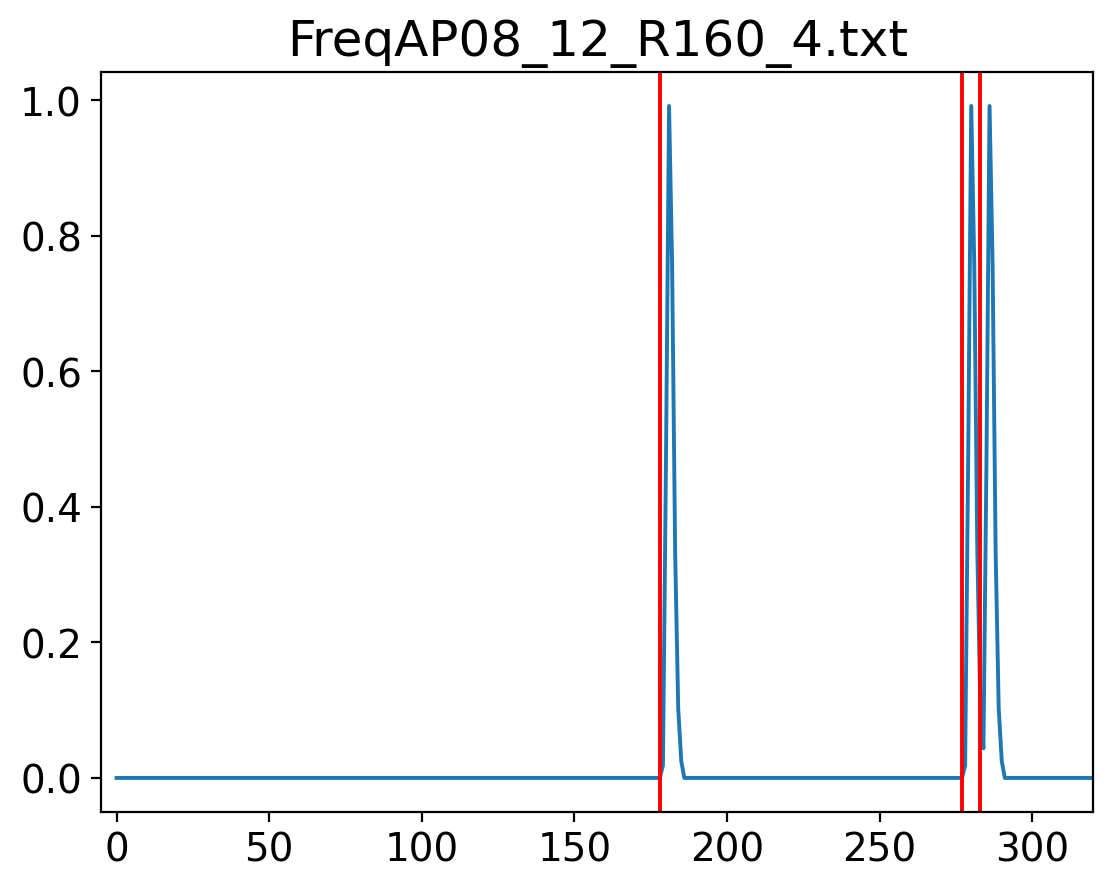

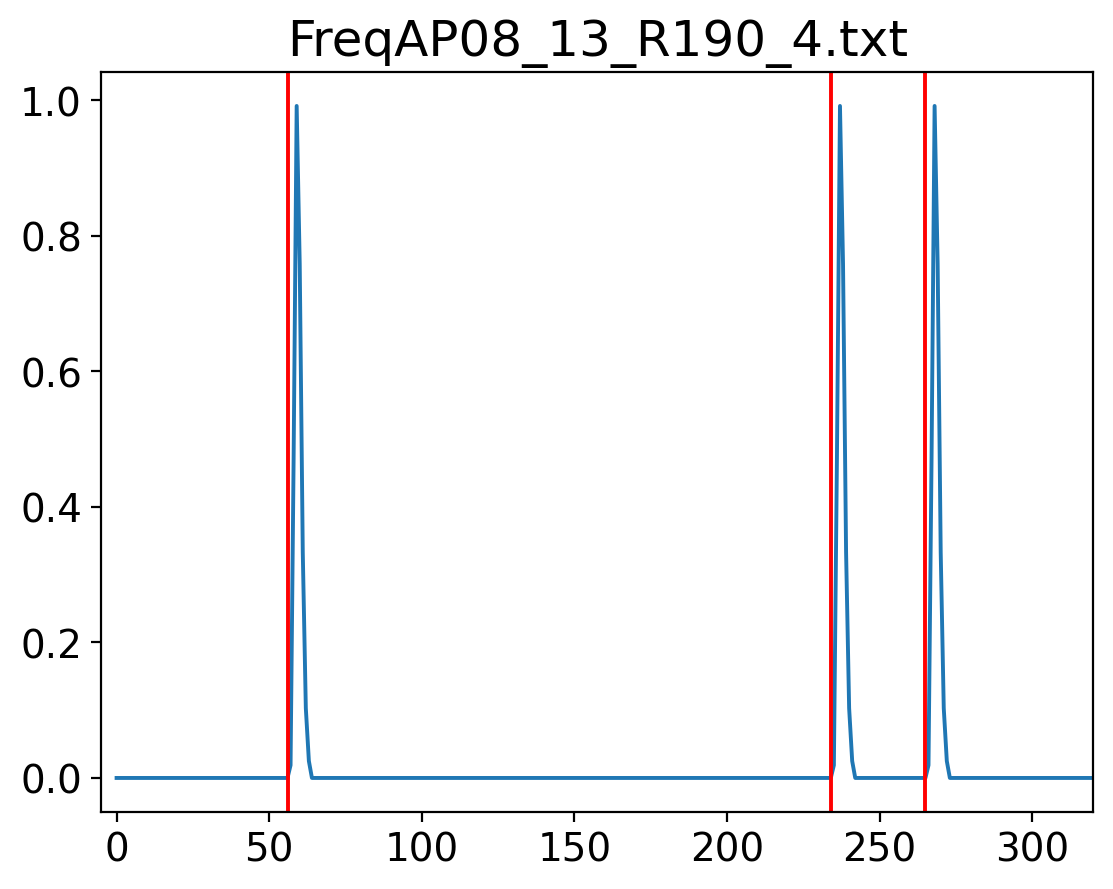

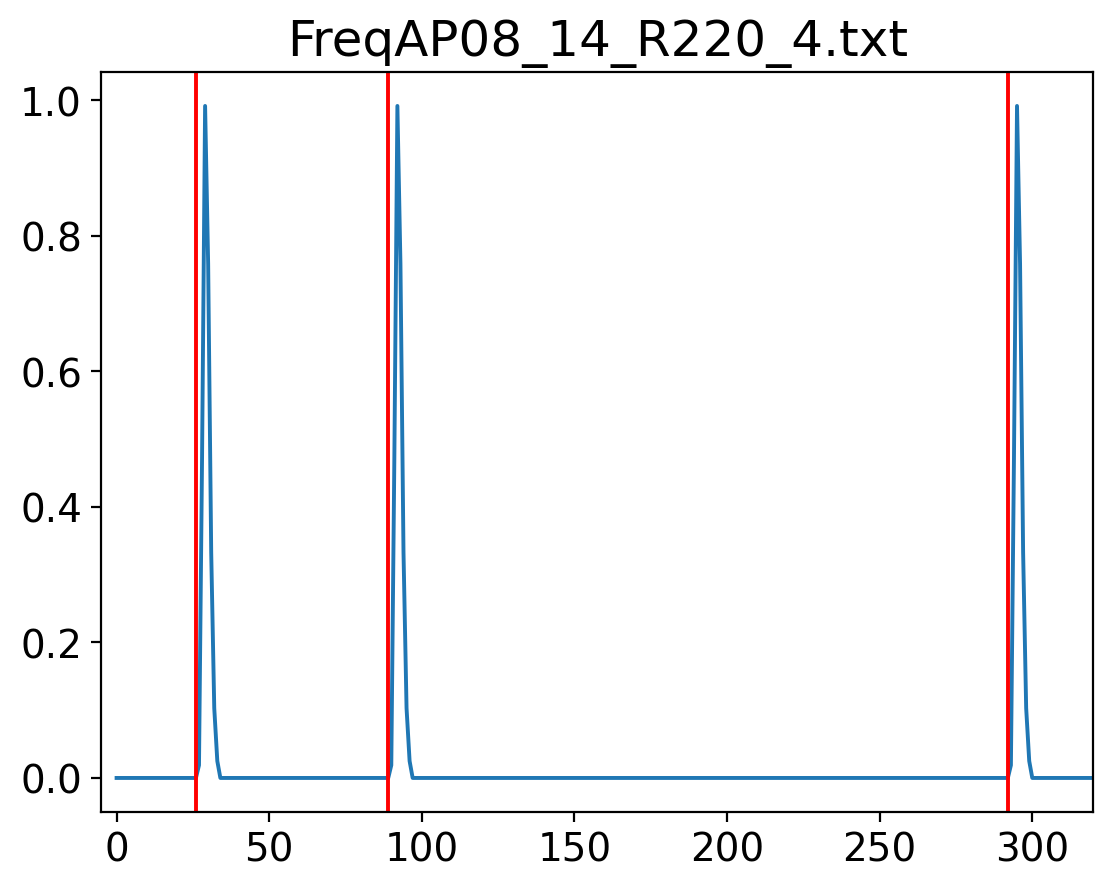

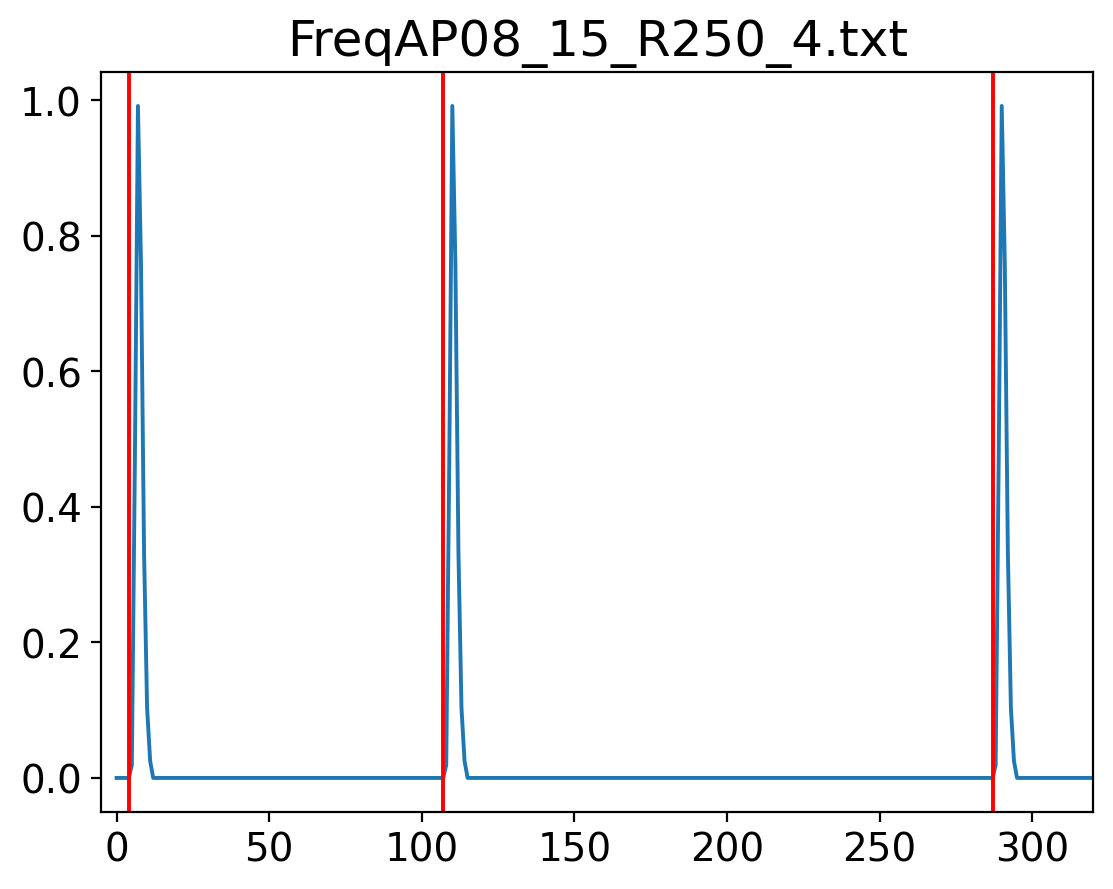

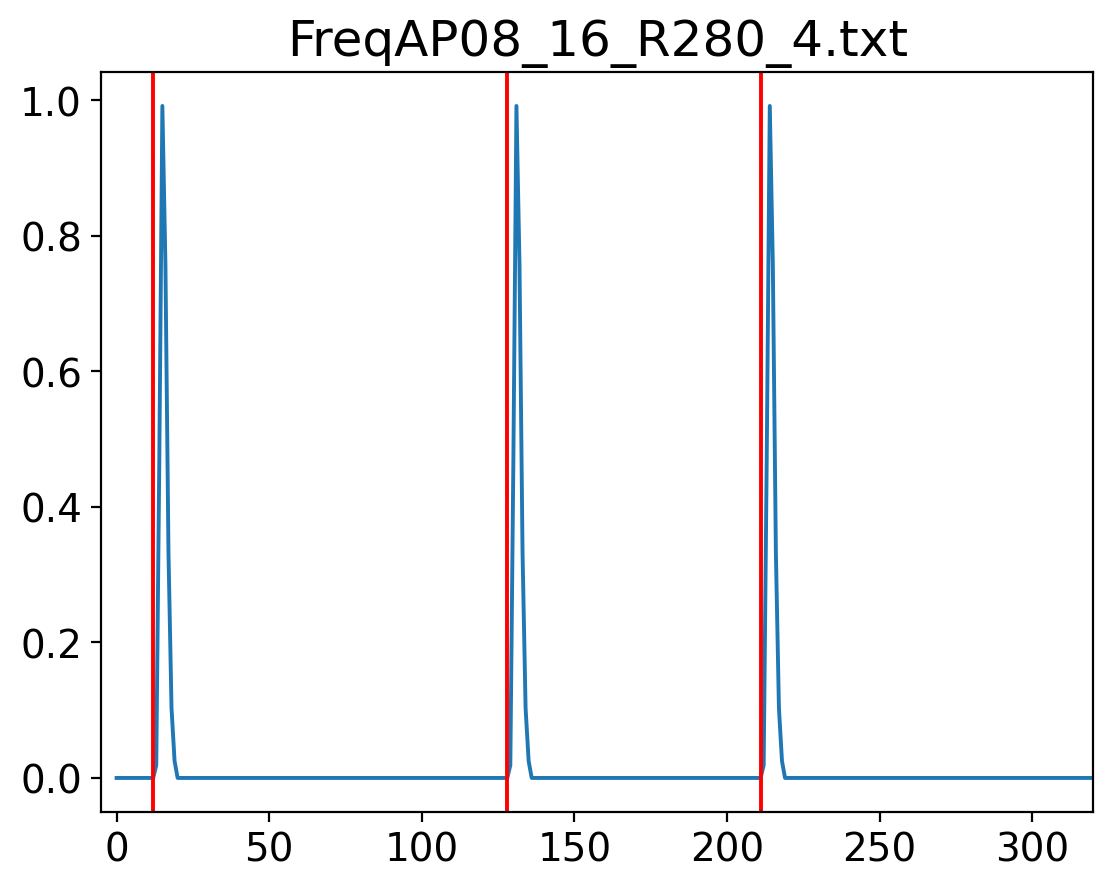

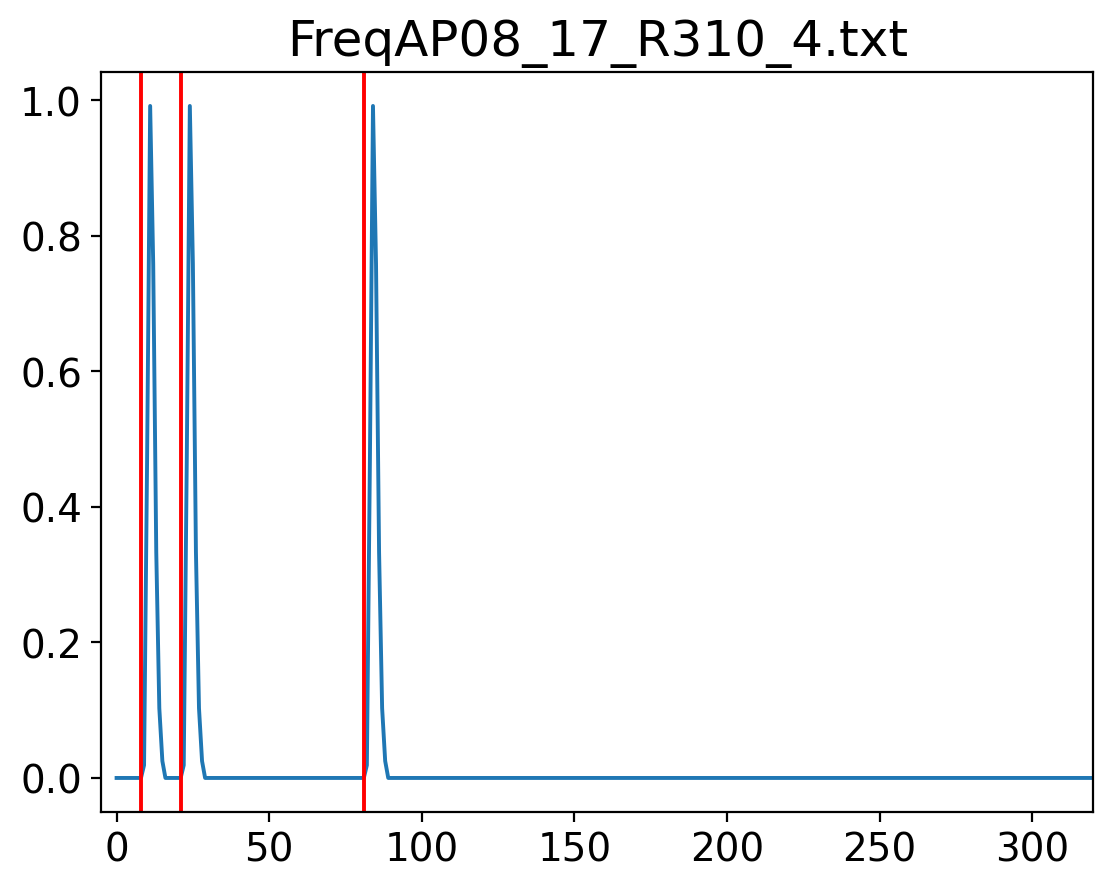

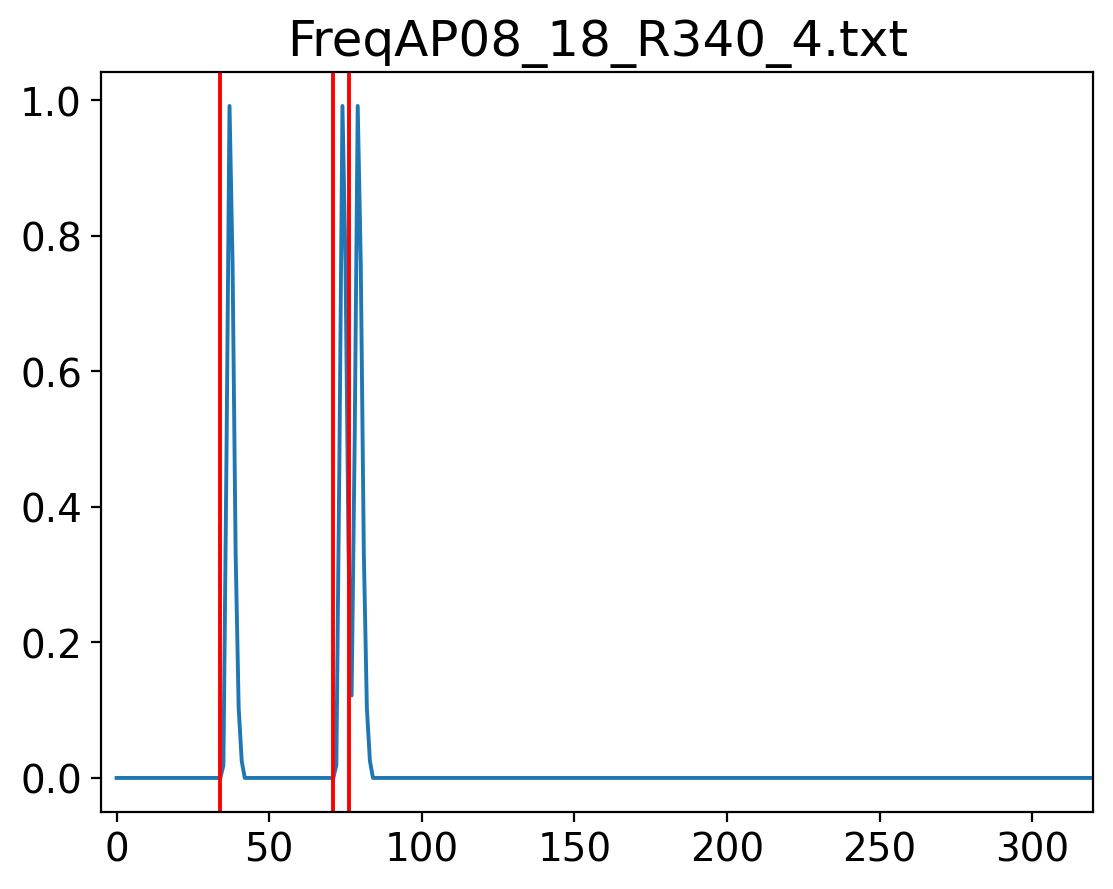

In [11]:
# vertical red lines indicate the input from the EventFiles folder.
# Timeseries shows the stimulus timeseries from the full_GLM stimulus matrix.
for i in range(18):
    plt.plot(condition_4_X_from_full_GLM[:, i])
    plt.axvline(x=transformed3_cond4[i][0], color="r")
    plt.axvline(x=transformed3_cond4[i][1], color="r")
    plt.axvline(x=transformed3_cond4[i][2], color="r")
    plt.xlim([-5, 320])
    plt.title(files_cond4[i])
    plt.show()

# Positive control works!!! AWESOME <3

What is the next step? I can obtain the scalar value output for every stimulus. Then, I will have a scalar value paired to every stimulus.

The following part is based on the notebook called: Mechanistic_model_with_data_sampling_rate.ipynb

$y \ = \ \sum_{i=1}^n \ \Big(\delta_L \cdot w_{i,L} \cdot c_i(s) \ + \ \delta_R \cdot w_{i,R}\cdot c_i(s) \Big) \ + \ \epsilon$

Think carefully. The stimulus have 2 components, a frequency and a hand component. The hand determines what set of weights should we use, if the left ones or the right ones.

In [14]:
def channel(x, mu=1, sigma=1):
    ''' Defines a single channel function based on a normal distribution. c
    '''
    return (np.exp(-(x-mu)**2/(2*sigma**2)))/(sigma*np.sqrt(2*np.pi))

# def scalar_value(stimulus_freq, hand, weights_left, weights_right, mus, sigmas):
#     ''' Applies the channel function to a single stimulus, c=c(s)
#         Depending on whether the hand string is "R" or "L", the appropriate set of weights is multiplied by the channel_outputs_at_stimulus.
#     '''
#     y = -100
#     channel_outputs_at_stimulus = np.asarray([channel(stimulus_freq, mus[i], sigmas[i]) for i in range(n_channels)])
    
#     if hand =="L":
#         y = np.sum(weights_left * channel_outputs_at_stimulus)
#     elif hand =="R":
#         y = np.sum(weights_right * channel_outputs_at_stimulus)
    
#     return y # If the output is -100, that means there is an error in the hand label

def scalar_value(stimulus, weights, mus, sigmas):
    ''' Applies the channel function to a single stimulus, c=c(s)
    '''
    channel_values = np.asarray([channel(stimulus, mus[i], sigmas[i]) for i in range(n_channels)])
    y = np.sum(weights * channel_values)
    return y


def yy_all_stim(n_timepoints, stimuli_freqs, stimuli_LR, stimuli_3values, weights_left, weights_right, mus, sigmas):
    # This function pairs all the stimulus with their scalar value through yy_vec
    # Additionally, it obtains the timeseries with the scalar values for the stimuli
    i = 0
    length = len(stimuli_freqs)
    yy_vec = np.zeros(length) # Vector of scalar values depending on the stimuli presented on stimuli_freqs
    yy_timeseries = np.zeros(n_timepoints) # Timeseries of zeros and scalar values
    
    for i in range(length): # Cycle that obtains all the scalar values associated with every stimulus.
        stimulus_freq = stimuli_freqs[i]
        
        if stimuli_LR[i] == "L":
            yy_vec[i] = scalar_value(stimulus_freq, weights_left, mus, sigmas)
        elif stimuli_LR[i] == "R":
            yy_vec[i] = scalar_value(stimulus_freq, weights_right, mus, sigmas)
        else:
            print("There was an error in the stimuli_LR variable.")

        # There is an error in the following part of the code.
        for stimuli_arg in stimuli_3values[i]: # This for loop stores the scalar value of that stimulus in the timeseries
            yy_timeseries[stimuli_arg] += yy_vec[i]

    return yy_timeseries, yy_vec

def HRF(t, A = 5, alpha_1 = 6, alpha_2 = 16, beta_1 = 1, beta_2 = 1, c = 1/6):
    ''' Hemodynamic response function (HRF) as defined in Friston 1998.
    '''
    numerator_1 = t**(alpha_1 - 1)*beta_1**(alpha_1) * np.exp(-beta_1*t)
    numerator_2 = t**(alpha_2 - 1)*beta_2**(alpha_2) * np.exp(-beta_2*t)
    return A * (numerator_1/math.gamma(alpha_1) - c*numerator_2/math.gamma(alpha_2))

In [15]:
n_channels = 9
n_timepoints = 316 # 2528
# stim_freq = 100
TR = 1.5 # in seconds. This is the sampling interval. See notes on Friday, April 18, 2025, specifically Goal 2.

# What's the difference between np.asarray and np.array?
# See here: https://stackoverflow.com/questions/14415741/what-is-the-difference-between-np-array-and-np-asarray
timeaxis_s = np.asarray([i*TR for i in range(n_timepoints)]) # time
timeaxis_min = timeaxis_s/60
t_hrf = timeaxis_s[:30]  # IS THIS RIGHT???

# Stimulus
stimuli_freqs = [100, 200]
stimuli_LR = ["L", "L"]
stimuli_3values = [[25, 50, 75], [225, 250, 275]]

# Parameters that define the channels
weights_left = [rd.random()*2-1 for i in range(n_channels)] # Values in the [-1, 1] range.
weights_right = [rd.random()*2-1 for i in range(n_channels)] # Values in the [-1, 1] range.
mus = np.asarray([50*i+50 for i in range(n_channels)])
sigmas = np.asarray([50 for i in range(n_channels)])

# yy = yy_vector(stimulus_vec, weights, mus, sigmas)
yy_timeseries, yy_vec = yy_all_stim(n_timepoints, stimuli_freqs, stimuli_LR, stimuli_3values, weights_left, weights_right, mus, sigmas)
# hrf = HRF(t_hrf)
# BOLD_predicted = np.convolve(yy, hrf)

Given those channels and weights, obtain the predicted values.

In [17]:
yy_vec

array([ 0.00731634, -0.00197571])

In [18]:
scalar_value(200, weights_left, mus, sigmas)

-0.0019757060727224247

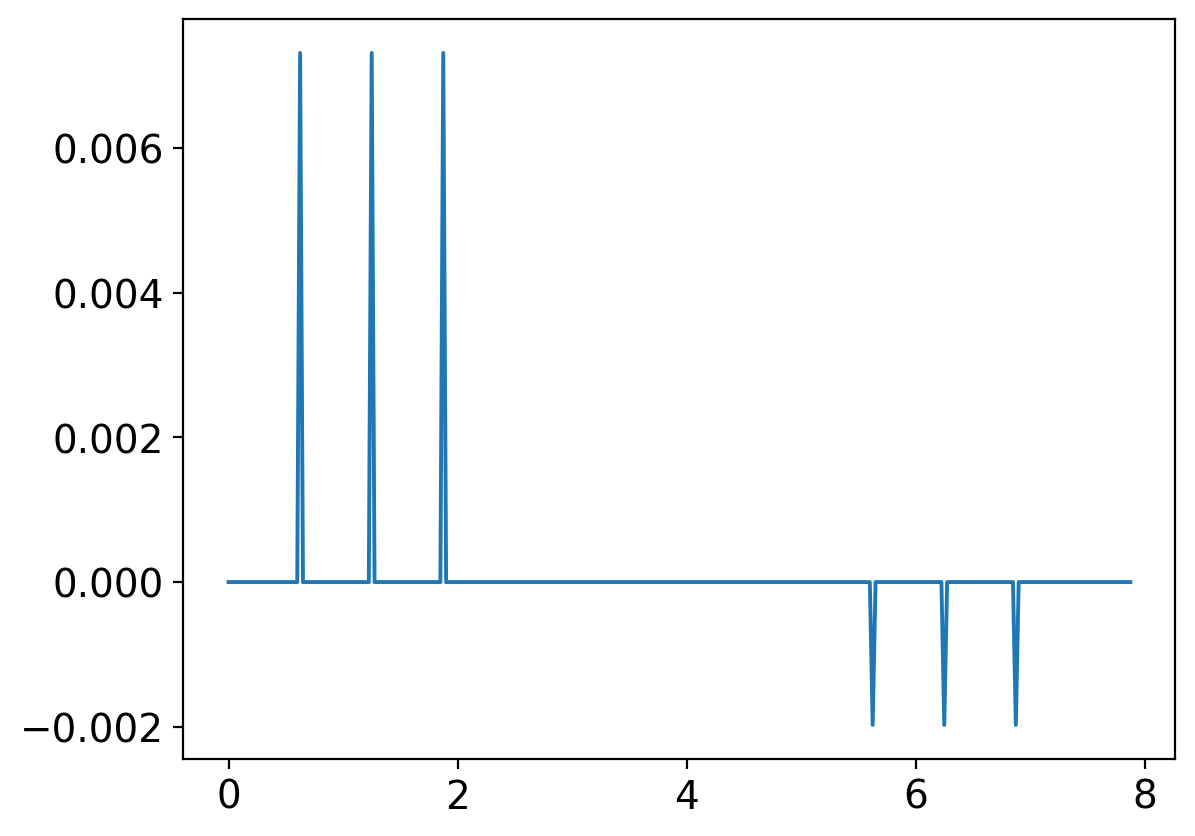

In [19]:
plt.plot(timeaxis_min, yy_timeseries)
plt.show()

Wuhuuuuuu! This is what I expected!!!

### Now you can put the 2 pieces together. Try the model in the real stimuli!
Modify the organization of the `transformed3_cond4` to the format of stimuli_freqs, stimuli_LR and stimuli_3values.

In [21]:
# Real stimuli
print("Input: ", files_cond4)
print("Output: ")
print(original3_cond4)
print(transformed3_cond4)
print(np.asarray(binary_matrix_cond4).shape)
print("The following value should be less than 316: ", max([max(l) for l in transformed3_cond4]))

Input:  ['FreqAP08_01_L100_4.txt', 'FreqAP08_02_L130_4.txt', 'FreqAP08_03_L160_4.txt', 'FreqAP08_04_L190_4.txt', 'FreqAP08_05_L220_4.txt', 'FreqAP08_06_L250_4.txt', 'FreqAP08_07_L280_4.txt', 'FreqAP08_08_L310_4.txt', 'FreqAP08_09_L340_4.txt', 'FreqAP08_10_R100_4.txt', 'FreqAP08_11_R130_4.txt', 'FreqAP08_12_R160_4.txt', 'FreqAP08_13_R190_4.txt', 'FreqAP08_14_R220_4.txt', 'FreqAP08_15_R250_4.txt', 'FreqAP08_16_R280_4.txt', 'FreqAP08_17_R310_4.txt', 'FreqAP08_18_R340_4.txt']
Output: 
[array([  0. , 205.5, 219. ]), array([ 91.5, 307.5, 444. ]), array([169.5, 186. , 225. ]), array([211.5, 376.5, 391.5]), array([252. , 403.5, 462. ]), array([ 63. , 342. , 409.5]), array([141., 198., 273.]), array([ 69., 240., 330.]), array([ 97.5, 232.5, 297. ]), array([150., 258., 357.]), array([ 45., 291., 363.]), array([267. , 415.5, 424.5]), array([ 84. , 351. , 397.5]), array([ 39. , 133.5, 438. ]), array([  6. , 160.5, 430.5]), array([ 18. , 192. , 316.5]), array([ 12. ,  31.5, 121.5]), array([ 51. , 1

In [22]:
n_freqs = 9
stimuli_aux = [100+i*30 for i in range(n_freqs)]
stimuli_freqs = np.concatenate((stimuli_aux,stimuli_aux))
stimuli_L_aux = ["L" for i in range(n_freqs)]
stimuli_R_aux = ["R" for i in range(n_freqs)]
stimuli_LR = np.concatenate((stimuli_L_aux,stimuli_R_aux))
stimuli_3values = transformed3_cond4

print(stimuli_freqs)
print(stimuli_LR)


[100 130 160 190 220 250 280 310 340 100 130 160 190 220 250 280 310 340]
['L' 'L' 'L' 'L' 'L' 'L' 'L' 'L' 'L' 'R' 'R' 'R' 'R' 'R' 'R' 'R' 'R' 'R']


In [23]:
# Implementing the model
n_channels = 9
n_timepoints = 316 # 2528
# stim_freq = 100
TR = 1.5 # in seconds. This is the sampling interval. See notes on Friday, April 18, 2025, specifically Goal 2.

# What's the difference between np.asarray and np.array?
# See here: https://stackoverflow.com/questions/14415741/what-is-the-difference-between-np-array-and-np-asarray
timeaxis_s = np.asarray([i*TR for i in range(n_timepoints)]) # time
timeaxis_min = timeaxis_s/60
# t_hrf = timeaxis_s[:30]  # IS THIS RIGHT???

# Stimulus
n_freqs = 9
stimuli_aux = [100+i*30 for i in range(n_freqs)]
stimuli_freqs = np.concatenate((stimuli_aux,stimuli_aux))
stimuli_L_aux = ["L" for i in range(n_freqs)]
stimuli_R_aux = ["R" for i in range(n_freqs)]
stimuli_LR = np.concatenate((stimuli_L_aux,stimuli_R_aux))
stimuli_3values = transformed3_cond4

print(stimuli_freqs)
print(stimuli_LR)

# Parameters that define the channels
weights_left = [rd.random()*2-1 for i in range(n_channels)] # Values in the [-1, 1] range.
weights_right = [rd.random()*2-1 for i in range(n_channels)] # Values in the [-1, 1] range.
mus = np.asarray([50*i+50 for i in range(n_channels)])
sigmas = np.asarray([50 for i in range(n_channels)])

yy_timeseries, yy_vec = yy_all_stim(n_timepoints, stimuli_freqs, stimuli_LR, stimuli_3values, weights_left, weights_right, mus, sigmas)
# hrf = HRF(t_hrf)
# BOLD_predicted = np.convolve(yy, hrf)

[100 130 160 190 220 250 280 310 340 100 130 160 190 220 250 280 310 340]
['L' 'L' 'L' 'L' 'L' 'L' 'L' 'L' 'L' 'R' 'R' 'R' 'R' 'R' 'R' 'R' 'R' 'R']


In [24]:
print(yy_vec)
scalar_value(100, weights_left, mus, sigmas)

[ 0.00161945 -0.0007826  -0.00502778 -0.00905883 -0.01038803 -0.00790673
 -0.00279276  0.00255176  0.00647038 -0.00648937 -0.00253806  0.00253673
  0.00647467  0.00812058  0.00662687  0.00188279 -0.00421223 -0.00866   ]


0.0016194488311198115

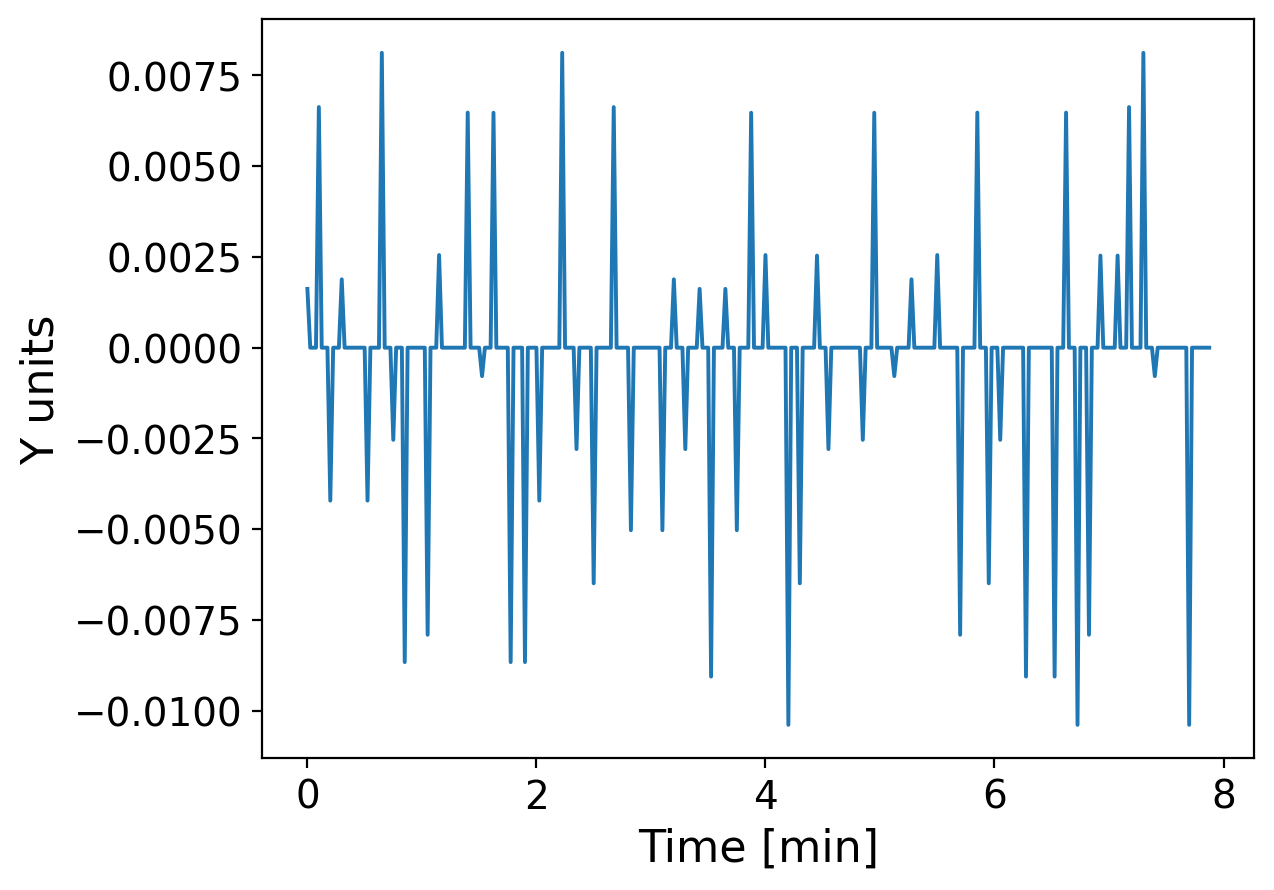

In [25]:
plt.plot(timeaxis_min, yy_timeseries)
plt.xlabel("Time [min]")
plt.ylabel("Y units")
plt.show()

AWESOME POINT TO END THE DAY WITH! The previous timeseries can be convolved with the HRF. Thanks to all those great artists that help me remain focused. 